# Introduction
To assess the quality of the MAGs and filter them, [Busco Evaluation](https://doi.org/10.1093/bioinformatics/btv351) will be used to generated the quality metrics. This will be the first part of the project that uses Euler to compute the moshpit commands

Our objective from this Notebook are:
- retrieve the quality metrics from the Busco Evaluation for Bacteria, Eukaryotes and Archaea
- compare the completeness and contamination score across the two sequencing techniques
## Setup

In [1]:
#set up environment
import pandas as pd
import qiime2 as q2
from qiime2 import Visualization

# create directories for the notebook. DO NOT change
busco_dir = 'data/processed/02_Busco_Eval'
!busco_dir = 'data/processed/02_Busco_Eval'

!mkdir -p data
!mkdir -p data/processed
!mkdir -p $busco_dir

# fetches useful files for the current notebook. All files will be saved in $busco_dir
!wget 'https://polybox.ethz.ch/index.php/s/T2nb3xp6aE6d8nq/download' -O data/processed/Download.zip
!unzip -o data/processed/Download.zip -d data/processed
!rm data/processed/Download.zip

/usr/bin/sh: line 1: busco_dir: command not found
--2025-12-18 23:17:30--  https://polybox.ethz.ch/index.php/s/T2nb3xp6aE6d8nq/download
Resolving polybox.ethz.ch (polybox.ethz.ch)... 129.132.71.243
Connecting to polybox.ethz.ch (polybox.ethz.ch)|129.132.71.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘data/processed/Download.zip’

data/processed/Down     [ <=>                ]   5.85M  --.-KB/s    in 0.1s    

2025-12-18 23:17:31 (41.7 MB/s) - ‘data/processed/Download.zip’ saved [6131177]

Archive:  data/processed/Download.zip
 extracting: data/processed/02_Busco_Eval/.ipynb_checkpoints/02_busco_eval.slurms-checkpoint.sh  
 extracting: data/processed/02_Busco_Eval/02_busco_eval.slurms.sh  
 extracting: data/processed/02_Busco_Eval/archaea_busco_results.qza  
 extracting: data/processed/02_Busco_Eval/bacteria_busco_results.qza  
 extracting: data/processed/02_Busco_Eval/eukaryota_busco_results.qza  
 extracting: d

## Euler setup
The MAGs have been uploaded manually to the *\${HOME}* directory on Euler at the end of the Data_Reshaping notebook. Before running the BUSCO evaluation, a cache has to be set up into the scratch directory and the MAGs imported into it.
Using a [cache](https://use.qiime2.org/en/latest/tutorials/use-the-artifact-cache.html?utm_source=chatgpt.com) stores Artifacts in their unzipped form (instead of the compressed .qza format), allowing faster access to it's content. This is useful for heavy datasets that cannot be loaded onto the memory all at once using memory-mapping. Secondarly it is a place for the computing node to save temporary files during computations.

# Busco Evaluation
The decision of running the MAGs against BUSCO's Bacteria, Eukaryota and Archeae ([v12](https://doi.org/10.1093/nar/gkae987)) lies in our knowledge of fermentation in food industry, where both bacteria (in cheese for example) and yeasts (beer, cheese, bread, etc.) play an key role. We included Archeae to satisfy our curiosity.

we use as imput the the mags stored in a cache for convenience and ease of access of the computation node.

the script below is made to run as a .slurms.sh script on the HPC. It fetches the needed busco DBs and and saves the results as artifacts for downstream use and ease preservation. (Available in $busco_dir)
It is essentially divided in 3 separate steps:
1. fetch the odb12 busco database for each of the 3 domains (Bacteria, Archaea and Eukaryota).
2. perform the BUSCO evaluation.
3. export the cache stored results as Artifacts.
4. compress and safe-keep the results.

<div style="border:2px solid red; padding:10px; color:red; font-weight:bold; text-align:center;">
  Output provided
</div>


```
#!/bin/bash
#SBATCH --job-name=busco_eval
#SBATCH --ntasks=1
#SBATCH --cpus-per-task=20
#SBATCH --mem-per-cpu=2G
#SBATCH --time=48:00:00
#SBATCH --output=/cluster/home/emotta/applied_bioinformatics/01_logs/%x_%j_out.log
#SBATCH --error=/cluster/home/emotta/applied_bioinformatics/01_logs/%x_%j_err.log

module load eth_proxy

# initialize conda manually
source /cluster/home/emotta/miniconda3/etc/profile.d/conda.sh
conda activate qiime2-moshpit-2025.7

CACHE_DIR=/cluster/scratch/emotta/cache
RESULT_DIR=/cluster/home/emotta/applied_bioinformatics/02_visualizations/
ARTIFACT_DIR=/cluster/scratch/emotta/03_artifacts


# 1. Fetch databases
# -----------------------

mosh annotate fetch-busco-db \
    --p-lineages bacteria_odb12 \
    --o-db $CACHE_DIR:bacteria_odb12 \
    --verbose
mosh annotate fetch-busco-db \
    --p-lineages eukaryota_odb12 \
    --o-db $CACHE_DIR:eukaryota_odb12 \
    --verbose
mosh annotate fetch-busco-db \
    --p-lineages archaea_odb12 \
    --o-db $CACHE_DIR:archaea_odb12 \
    --verbose

# 2. BUSCO evaluation 
#-------------------------

### Busco x Bacteria
mosh annotate evaluate-busco \
    --i-mags $CACHE_DIR:mags \
    --i-db $CACHE_DIR:bacteria_odb12 \
    --p-lineage-dataset bacteria_odb12 \
    --p-cpu 20 \
    --o-visualization $RESULT_DIR/bacteria_odb12.qzv \
    --o-results $CACHE_DIR:bacteria_odb12_busco_results \
    --verbose
### Busco x Eukaryota
mosh annotate evaluate-busco \
    --i-mags $CACHE_DIR:mags \
    --i-db $CACHE_DIR:eukaryota_odb12 \
    --p-lineage-dataset eukaryota_odb12 \
    --p-cpu 20 \
    --o-visualization $RESULT_DIR/eukaryota_odb12.qzv \
    --o-results $CACHE_DIR:eukaryota_odb12_busco_results \
    --verbose
conda deactivate
source /cluster/home/emotta/miniconda3/etc/profile.d/conda.sh
conda activate qiime2-moshpit-2025.7
### Busco x Archaea
mosh annotate evaluate-busco \
    --i-mags $CACHE_DIR:mags \
    --i-db $CACHE_DIR:archaea_odb12 \
    --p-lineage-dataset archaea_odb12 \
    --p-cpu 20\
    --o-visualization $RESULT_DIR/archaea_odb12.qzv \
    --o-results $CACHE_DIR:archaea_odb12_results \
    --verbose
    

# 3. Create Artifacts
#----------------------------

conda deactivate
source /cluster/home/emotta/miniconda3/etc/profile.d/conda.sh
conda activate qiime2-moshpit-2025.7
#bacteria
mosh tools cache-fetch \
  --cache $CACHE_DIR \
  --key bacteria_odb12_busco_results \
  --output-path $ARTIFACT_DIR/busco/bacteria_odb12_busco_results.qza
#eukaryota
mosh tools cache-fetch \
  --cache $CACHE_DIR \
  --key eukaryota_odb12_busco_results \
  --output-path $ARTIFACT_DIR/busco/eukaryota_odb12_busco_results.qza
#archaea
mosh tools cache-fetch \
  --cache $CACHE_DIR \
  --key archaea_odb12_results \
  --output-path $ARTIFACT_DIR/busco/archaea_odb12_busco_results.qza
# deactivate conda environment
conda deactivate
```

## Chapter 2: Visualization
The quality scores have been generated and are ready to be plotted. 
- subset the data per sequencing Technique
- remove NaN quality scores.
- Scatter plot all MAGs quality score for each domain to compare sequencing technique MAGs.
- Compare the frequency of MAGs that pass the Medium quality threshold.

In [2]:
#load artifacts as dataframes for plotting
archaea_busco= q2.Artifact.load(f'{busco_dir}/archaea_busco_results.qza').view(pd.DataFrame)
bacteria_busco= q2.Artifact.load(f'{busco_dir}/bacteria_busco_results.qza').view(pd.DataFrame)
eukaryota_busco=q2.Artifact.load(f'{busco_dir}/eukaryota_busco_results.qza').view(pd.DataFrame)

/opt/conda/lib/python3.10/site-packages/unifrac/__init__.py:9: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [3]:
def prepare_busco(busco_df, prefix="IL_"):
    ''' subset the dataframes based on the prefix in sample_id. Drops NaN values in quality metrics before returning'''
    filtered_df = busco_df[busco_df["sample_id"].str.startswith(prefix)].copy()
    return filtered_df.dropna(subset=['completeness', 'contamination'])


In [4]:
IL_bacteria = prepare_busco(bacteria_busco, prefix = 'IL_')
IL_archaea = prepare_busco(archaea_busco, prefix = 'IL_')
IL_eukaryota = prepare_busco(eukaryota_busco, prefix = 'IL_')

PB_bacteria = prepare_busco(bacteria_busco, prefix = 'PB_')
PB_archaea = prepare_busco(archaea_busco, prefix = 'PB_')
PB_eukaryota = prepare_busco(eukaryota_busco, prefix = 'PB_')


this part of the code will be used to compare the different sequencing techniques. At the moment does not do anything for the final visualization. For now please run it despite possible errors.

In [5]:
def get_xy(busco_df, x_col='completeness', y_col='contamination'):
    ''' Create a list for each quality metrics. This makes it more readable for plotting'''
    x = busco_df[x_col].astype(float)
    y = busco_df[y_col].astype(float)
    return x, y


since there are 3 df, but the one hot encoding works for all of them the same

In [6]:
### Scatterplot with histograms
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pandas as pd

def scatter_hist(x, y, ax, ax_histx, ax_histy, color_type):
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.set_xlim(0, 100)
    ax.set_ylim(0, 100)
    ax_histx.set_xlim(0, 100)
    ax_histy.set_ylim(0, 100)

    ax.scatter(x, y, s=10, alpha=0.3, color = color_type)

    ax.plot([50,100], [10,10], '--', linewidth=2, color='green')
    ax.plot([50,50], [0,10], '--', linewidth=2, color='green')

    bins = np.arange(0, 101, 5)

    ax_histx.hist(x, bins=bins, color = color_type, alpha=0.7, histtype = 'step')
    ax_histy.hist(y, bins = bins, orientation ='horizontal', color = color_type, alpha=0.7, histtype = 'step')


In [7]:
x_IL_bacteria, y_IL_bacteria = get_xy(IL_bacteria)
x_PB_bacteria, y_PB_bacteria = get_xy(PB_bacteria)
x_IL_archaea, y_IL_archaea = get_xy(IL_archaea)
x_PB_archaea, y_PB_archaea = get_xy(PB_archaea)
x_IL_eukaryota, y_IL_eukaryota = get_xy(IL_eukaryota)
x_PB_eukaryota, y_PB_eukaryota = get_xy(PB_eukaryota)

Create variables for x and y of every subset. To do so a small function *get_xy*.

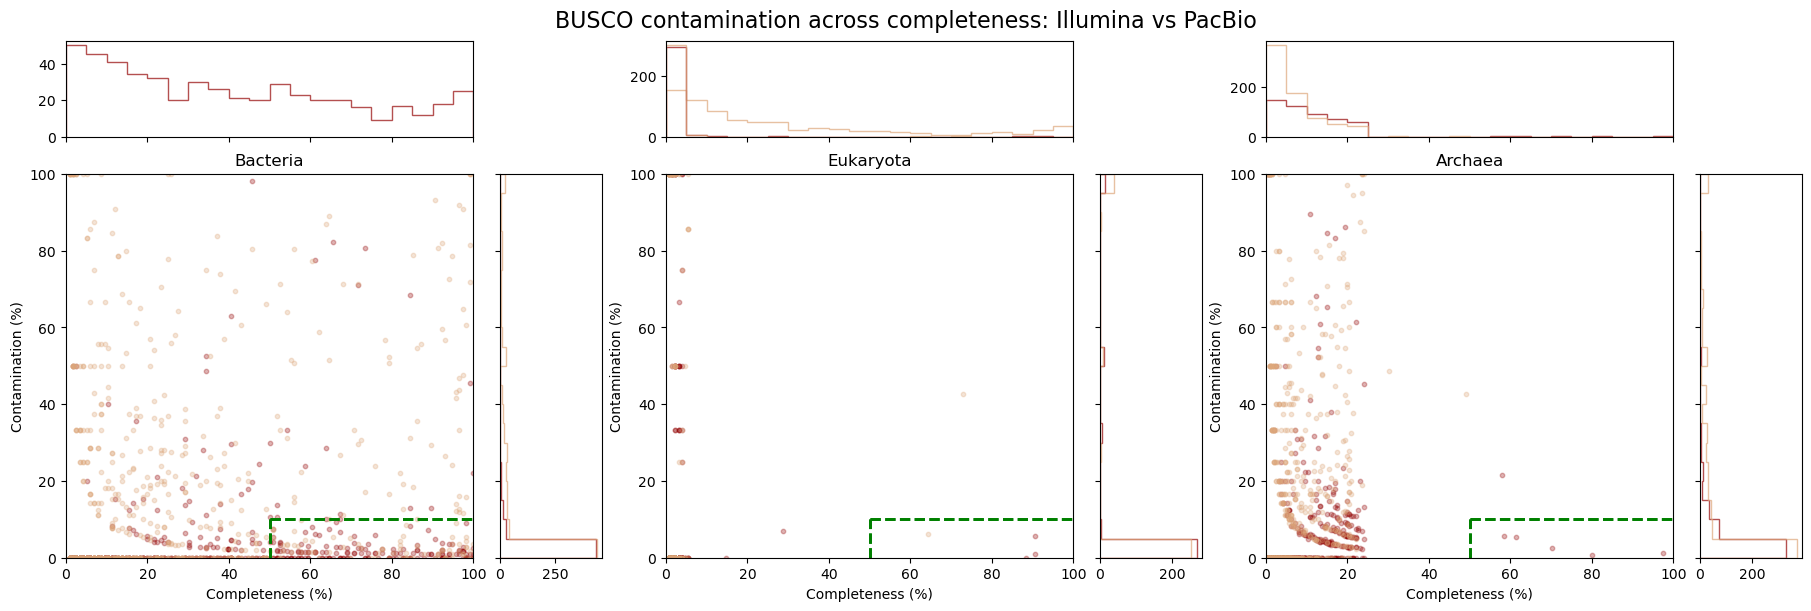

In [20]:
layout = [
    ['histx1', '.',      'histx2', '.',      'histx3', '.'],
    ['scatter1', 'histy1', 'scatter2', 'histy2', 'scatter3', 'histy3']
]

fig, axs = plt.subplot_mosaic(
    layout,
    figsize=(18, 6),
    width_ratios=[4,1]*3,   # repeats 3 times
    height_ratios=[1,4],
    layout='constrained'
)

# Bacteria
scatter_hist( # Illumina
    x=x_IL_bacteria,
    y=y_IL_bacteria,
    ax=axs['scatter1'],
    ax_histx=axs['histx1'],
    ax_histy=axs['histy1'],
    color_type='#950606'
)
scatter_hist( # PacBio
    x=x_PB_bacteria,
    y=y_PB_bacteria,
    ax=axs['scatter1'],
    ax_histx=axs['histx2'],
    ax_histy=axs['histy1'],
    color_type='#DDA77B'
)

# Eukaryota
scatter_hist( # Illumina
    x=x_IL_eukaryota,
    y=y_IL_eukaryota,
    ax=axs['scatter2'],
    ax_histx=axs['histx2'],
    ax_histy=axs['histy2'],
    color_type='#950606'
)
scatter_hist( # PacBio
    x=x_PB_eukaryota,
    y=y_PB_eukaryota,
    ax=axs['scatter2'],
    ax_histx=axs['histx2'],
    ax_histy=axs['histy2'],
    color_type='#DDA77B'
)

# Archaea
scatter_hist( # Illumina
    x=x_IL_archaea,
    y=y_IL_archaea,
    ax=axs['scatter3'],
    ax_histx=axs['histx3'],
    ax_histy=axs['histy3'],
    color_type='#950606'
)
scatter_hist( # PacBio
    x=x_PB_archaea,
    y=y_PB_archaea,
    ax=axs['scatter3'],
    ax_histx=axs['histx3'],
    ax_histy=axs['histy3'],
    color_type='#DDA77B'
)
# Axis labels (scatter panels only)
axs['scatter1'].set_xlabel('Completeness (%)')
axs['scatter1'].set_ylabel('Contamination (%)')

axs['scatter2'].set_xlabel('Completeness (%)')
axs['scatter2'].set_ylabel('Contamination (%)')

axs['scatter3'].set_xlabel('Completeness (%)')
axs['scatter3'].set_ylabel('Contamination (%)')

# Panel titles
axs['scatter1'].set_title('Bacteria')
axs['scatter2'].set_title('Eukaryota')
axs['scatter3'].set_title('Archaea')

# Figure title
fig.suptitle('BUSCO contamination across completeness: Illumina vs PacBio', fontsize=16)

plt.savefig("data/Visualizations/Busco.svg", transparent=True)
plt.show()


## Filtering
Analyze the medium quality mags to asses the ability of each techniques to generate useful mags

In [9]:
def prepare_and_filter_busco(busco_df, prefix=None, min_completeness=50, max_contamination=10):
    """
    Filter and preprocess a BUSCO DataFrame.
    
    Steps:
    1. Optionally filter by sample_id prefix.
    2. Convert 'completeness' and 'contamination' to float.
    3. Drop rows with NaNs in completeness or contamination.
    4. Filter by completeness >= min_completeness and contamination < max_contamination.
    
    Parameters
    ----------
    busco_df : pd.DataFrame
        BUSCO results dataframe containing 'sample_id', 'completeness', 'contamination'.
    prefix : str or None
        Optional prefix to filter sample_id.
    min_completeness : float
        Minimum completeness to keep.
    max_contamination : float
        Maximum contamination to keep.
    
    Returns
    -------
    pd.DataFrame
        Preprocessed and filtered BUSCO DataFrame.
    """
    
    df = busco_df.copy()
    
    # Filter by prefix if given
    if prefix is not None:
        df = df[df['sample_id'].str.startswith(prefix)]
    
    # Convert to float
    df['completeness'] = df['completeness'].astype(float)
    df['contamination'] = df['contamination'].astype(float)
    
    # Drop NaNs
    df = df.dropna(subset=['completeness', 'contamination'])
    
    # Apply filtering thresholds
    df = df[(df['completeness'] >= min_completeness) & (df['contamination'] < max_contamination)]
    
    return df


In [10]:
IL_bacteria_filtered = prepare_and_filter_busco(bacteria_busco, prefix='IL_')
IL_archaea_filtered = prepare_and_filter_busco(archaea_busco, prefix='IL_')
IL_eukaryota_filtered = prepare_and_filter_busco(eukaryota_busco, prefix='IL_')

PB_bacteria_filtered = prepare_and_filter_busco(bacteria_busco, prefix='PB_')
PB_archaea_filtered = prepare_and_filter_busco(archaea_busco, prefix='PB_')
PB_eukaryota_filtered = prepare_and_filter_busco(eukaryota_busco, prefix='PB_')


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Mapping dataset codes to full names
dataset_names = {'IL': 'Illumina', 'PB': 'PacBio'}

# Initial sequence counts
initial_counts = {'Illumina': 544, 'PacBio': 882}

# Filtered DataFrames (already created)
filtered_dfs = {
    'IL_bacteria': IL_bacteria_filtered,
    'IL_archaea': IL_archaea_filtered,
    'IL_eukaryota': IL_eukaryota_filtered,
    'PB_bacteria': PB_bacteria_filtered,
    'PB_archaea': PB_archaea_filtered,
    'PB_eukaryota': PB_eukaryota_filtered
}

domains = ['bacteria', 'archaea', 'eukaryota']
datasets = ['IL', 'PB']

# Prepare summary table
summary = []

for domain in domains:
    for dataset in datasets:
        key = f"{dataset}_{domain}"
        df_filtered = filtered_dfs[key]
        dataset_full = dataset_names[dataset]  # map to full name
        count_filtered = len(df_filtered)
        percent_filtered = count_filtered / initial_counts[dataset_full] * 100
        summary.append({
            'Domain': domain.capitalize(),
            'Dataset': dataset_full,
            'Count': count_filtered,
            'Percentage': percent_filtered
        })

summary_df = pd.DataFrame(summary)
print(summary_df)


      Domain   Dataset  Count  Percentage
0   Bacteria  Illumina    170   31.250000
1   Bacteria    PacBio     78    8.843537
2    Archaea  Illumina      5    0.919118
3    Archaea    PacBio      0    0.000000
4  Eukaryota  Illumina      3    0.551471
5  Eukaryota    PacBio      1    0.113379


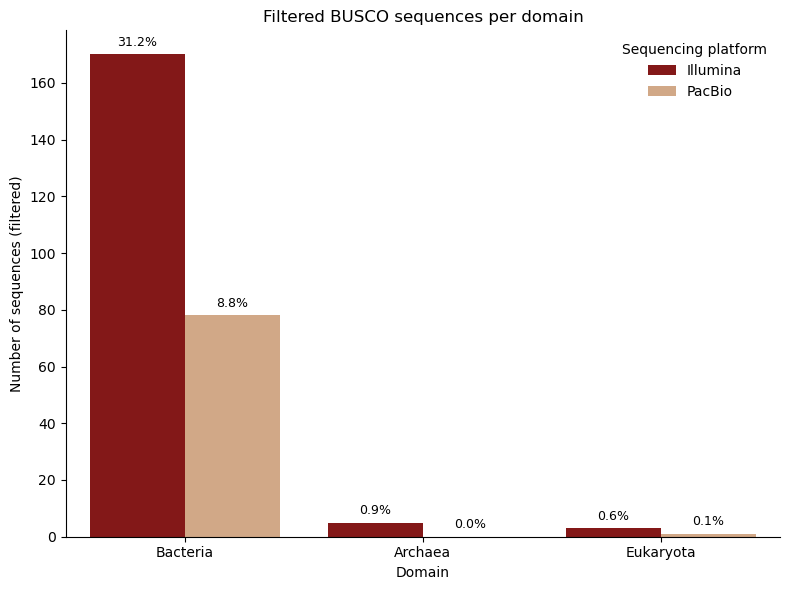

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define colors and hue order
colors = {'Illumina':'#950606', 'PacBio':'#DDA77B'}
hue_order = ['Illumina', 'PacBio']

plt.figure(figsize=(8,6))

# Create barplot
barplot = sns.barplot(
    data=summary_df,
    x='Domain',
    y='Count',
    hue='Dataset',
    palette=colors,
    hue_order=hue_order
)

# Add percentage labels above each bar
# Group by domain without sorting to preserve x-axis order
domain_groups = summary_df.groupby('Domain', sort=False)

for i, (domain, group) in enumerate(domain_groups):
    for j, row in group.iterrows():
        # Offset for hue bars
        x = i - 0.2 if row['Dataset']=='Illumina' else i + 0.2
        y = row['Count']
        plt.text(x, y + 2, f"{row['Percentage']:.1f}%", ha='center', va='bottom', fontsize=9)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Legend without frame
plt.legend(title='Sequencing platform', frameon=False)
        
plt.ylabel('Number of sequences (filtered)')
plt.title('Filtered BUSCO sequences per domain')
plt.tight_layout()
plt.savefig("data/Visualizations/Buscofiltered.svg", transparent=True)
plt.show()


## Look at the 2 samples that have passed all filtering metrics for all 3 domains
while looking at the filtered results, 2 MAGs appear in all 3 results. Next is to investigate them individually.

In [13]:
ids = [
    "09ebb84d-e6d1-4c36-871b-45bee0ad115d",
    "b016ed44-d4d7-4927-b6fc-b8eb341adbf7",
]

dfs = {
    "archaea": archaea_busco,
    "bacteria": bacteria_busco,
    "eukaryota": eukaryota_busco,
}

for name, df in dfs.items():
    present = df.index.intersection(ids)
    missing = set(ids) - set(present)
    print(f"{name}:")
    print("  present :", list(present))
    print("  missing :", list(missing))


archaea:
  present : ['09ebb84d-e6d1-4c36-871b-45bee0ad115d', 'b016ed44-d4d7-4927-b6fc-b8eb341adbf7']
  missing : []
bacteria:
  present : ['09ebb84d-e6d1-4c36-871b-45bee0ad115d', 'b016ed44-d4d7-4927-b6fc-b8eb341adbf7']
  missing : []
eukaryota:
  present : ['09ebb84d-e6d1-4c36-871b-45bee0ad115d', 'b016ed44-d4d7-4927-b6fc-b8eb341adbf7']
  missing : []


In [14]:
archaea_sub    = archaea_busco.loc[archaea_busco.index.intersection(ids)]
bacteria_sub   = bacteria_busco.loc[bacteria_busco.index.intersection(ids)]
eukaryota_sub  = eukaryota_busco.loc[eukaryota_busco.index.intersection(ids)]

In [15]:
# select only completeness and contamination columns
cols = ["completeness", "contamination"]

archaea_comp = archaea_sub[cols]
bacteria_comp = bacteria_sub[cols]
eukaryota_comp = eukaryota_sub[cols]

# combine into a single DataFrame for easier comparison
comparison = pd.concat(
    [archaea_comp, bacteria_comp, eukaryota_comp],
    keys=["archaea", "bacteria", "eukaryota"]
)
print(comparison)


                                               completeness contamination
          id                                                             
archaea   09ebb84d-e6d1-4c36-871b-45bee0ad115d         61.5           5.4
          b016ed44-d4d7-4927-b6fc-b8eb341adbf7         58.5           5.7
bacteria  09ebb84d-e6d1-4c36-871b-45bee0ad115d         50.9           4.1
          b016ed44-d4d7-4927-b6fc-b8eb341adbf7         50.9           7.5
eukaryota 09ebb84d-e6d1-4c36-871b-45bee0ad115d         90.7           5.7
          b016ed44-d4d7-4927-b6fc-b8eb341adbf7         88.4           0.0


From the quality scores, these MAGs have been assigned to the eukaryota set.